In [36]:
!pip install gdown tensorflow scikit-learn matplotlib Pillow numpy

In [2]:
import gdown
import zipfile

gdown.download("https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ", "dataset.zip", quiet=False)
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extraído exitosamente.")


Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=267c6cea-35b9-497a-b58e-acf630fe8f6e
To: /Users/pepeargentoo/AAII-2/dataset.zip
100%|██████████| 363M/363M [00:33<00:00, 10.9MB/s] 


Dataset extraído exitosamente.


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, Add,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [33]:
def is_directory_empty(directory):
    """Verifica si un directorio está vacío."""
    if not os.path.exists(directory):
        print(f"El directorio {directory} no existe.")
        return True
    return len(os.listdir(directory)) == 0


class SceneClassifier:
    """Clasificador de escenas naturales con redes neuronales."""

    def __init__(self, train_dir, test_dir, target_size=(150, 150), 
                 batch_size=32):
        """
        Inicializa la clase con los parámetros necesarios.

        Args:
            train_dir (str): Ruta del directorio de entrenamiento.
            test_dir (str): Ruta del directorio de prueba.
            target_size (tuple): Tamaño de las imágenes (ancho, alto).
            batch_size (int): Tamaño del batch para entrenamiento.
        """
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.models = {}
        self.history = {}

    def load_data(self):
        """Carga y preprocesa los datos de entrenamiento y prueba."""
        try:
            train_datagen = ImageDataGenerator(rescale=1.0 / 255)
            test_datagen = ImageDataGenerator(rescale=1.0 / 255)

            self.train_generator = train_datagen.flow_from_directory(
                self.train_dir, target_size=self.target_size, 
                batch_size=self.batch_size, class_mode='categorical'
            )
            self.test_generator = test_datagen.flow_from_directory(
                self.test_dir, target_size=self.target_size, 
                batch_size=self.batch_size, class_mode='categorical'
            )
            print("Datos cargados exitosamente.")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    def build_dense_model(self):
        """Construye un modelo denso."""
        try:
            model = Sequential([
                Flatten(input_shape=(*self.target_size, 3)),
                Dense(128, activation='relu'),
                Dense(6, activation='softmax')
            ])
            self._compile_model(model, 'dense')
        except Exception as e:
            print(f"Error al construir el modelo denso: {e}")

    def build_cnn_model(self):
        """Construye un modelo CNN."""
        try:
            model = Sequential([
                Conv2D(32, (3, 3), activation='relu', 
                       input_shape=(*self.target_size, 3)),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(6, activation='softmax')
            ])
            self._compile_model(model, 'cnn')
        except Exception as e:
            print(f"Error al construir el modelo CNN: {e}")

    def build_residual_model(self):
        """Construye un modelo con bloque residual."""
        try:
            input_layer = Input(shape=(*self.target_size, 3))
            x = Conv2D(32, (3, 3), activation='relu', 
                       padding='same')(input_layer)
            x = Conv2D(32, (3, 3), activation='relu', 
                       padding='same')(x)
            input_transformed = Conv2D(32, (1, 1), 
                                       padding='same')(input_layer)
            residual = Add()([input_transformed, x])
            x = Flatten()(residual)
            output_layer = Dense(6, activation='softmax')(x)

            model = Model(inputs=input_layer, outputs=output_layer)
            self._compile_model(model, 'residual')
        except Exception as e:
            print(f"Error al construir el modelo residual: {e}")

    def build_transfer_model(self):
        """Construye un modelo usando EfficientNetB0."""
        try:
            base_model = EfficientNetB0(weights='imagenet', 
                                        include_top=False,
                                        input_shape=(*self.target_size, 3))
            base_model.trainable = False

            model = Sequential([
                base_model,
                GlobalAveragePooling2D(),
                Dense(128, activation='relu'),
                Dense(6, activation='softmax')
            ])
            self._compile_model(model, 'efficientnet')
        except Exception as e:
            print(f"Error al construir el modelo de transferencia: {e}")

    def _compile_model(self, model, name):
        """Compila el modelo con las métricas necesarias."""
        try:
            model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(name='precision'), 
                         Recall(name='recall'), AUC(name='auc')]
            )
            self.models[name] = model
        except Exception as e:
            print(f"Error al compilar el modelo {name}: {e}")

    def train(self, model_name, epochs=5):
        """Entrena un modelo con EarlyStopping."""
        try:
            model = self.models[model_name]
            early_stop = EarlyStopping(
                monitor='val_loss', patience=3, restore_best_weights=True
            )

            history = model.fit(
                self.train_generator, epochs=epochs, 
                validation_data=self.test_generator, callbacks=[early_stop]
            )
            self.history[model_name] = history
        except Exception as e:
            print(f"Error durante el entrenamiento: {e}")

    def evaluate(self, model_name):
        """Evalúa un modelo y muestra las métricas."""
        try:
            model = self.models[model_name]
            y_true = self.test_generator.classes
            y_pred = np.argmax(model.predict(self.test_generator), axis=1)

            print(f"Resultados para {model_name}:")
            print(classification_report(
                y_true, y_pred, 
                target_names=self.test_generator.class_indices.keys(), 
                zero_division=1
            ))

            ConfusionMatrixDisplay.from_predictions(
                y_true, y_pred, 
                display_labels=self.test_generator.class_indices.keys()
            )
            plt.show()
        except Exception as e:
            print(f"Error al evaluar el modelo: {e}")

    def predict(self, model_name, image_path):
        """Realiza una predicción sobre una imagen."""
        try:
            if model_name not in self.models:
                raise ValueError(f"Modelo no entrenado: {model_name}")

            original_img = Image.open(image_path)
            img = original_img.resize(self.target_size)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            model = self.models[model_name]
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            class_indices = self.train_generator.class_indices
            class_labels = {v: k for k, v in class_indices.items()}
            predicted_label = class_labels[predicted_class]

            plt.imshow(original_img)
            plt.title(f"Clase predicha: {predicted_label}", 
                      fontsize=18, color='blue')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error durante la predicción: {e}")

    def plot_history(self, model_name):
        """Grafica la pérdida y precisión del modelo."""
        try:
            history = self.history[model_name]
            plt.figure(figsize=(14, 5))

            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida Validación')
            plt.title(f'{model_name} - Pérdida')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], 
                     label='Precisión Entrenamiento')
            plt.plot(history.history['val_accuracy'], 
                     label='Precisión Validación')
            plt.title(f'{model_name} - Precisión')
            plt.legend()

            plt.show()
        except Exception as e:
            print(f"Error al graficar la historia: {e}")


# Cargar los dataset

In [34]:
classifier = SceneClassifier(
    train_dir='seg_train/seg_train',
    test_dir='seg_test/seg_test',
)
classifier.load_data()

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Datos cargados exitosamente.


# Construir los modelos de capas Densa

Epoch 1/2


/Users/pepeargentoo/AAII-2/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/pepeargentoo/AAII-2/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3109 - auc: 0.6332 - loss: 6.5597 - precision: 0.3425 - recall: 0.2413 - val_accuracy: 0.2607 - val_auc: 0.6017 - val_loss: 1.6627 - val_precision: 0.8105 - val_recall: 0.1183
Epoch 2/2
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.3141 - auc: 0.6574 - loss: 1.6169 - precision: 0.8561 - recall: 0.1170 - val_accuracy: 0.3430 - val_auc: 0.7034 - val_loss: 1.6043 - val_precision: 0.8329 - val_recall: 0.1180
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Resultados para dense:
              precision    recall  f1-score   support

   buildings       1.00      0.00      0.00       437
      forest       0.17      0.12      0.14       474
     glacier       0.26      0.01      0.03       553
    mountain       0.17      0.73      0.28       525
         sea       0.00      0.00      0.00       510
      street       0.13      0.09      0.11       501

    accuracy                           0.16      3000
   macro avg       0.29    

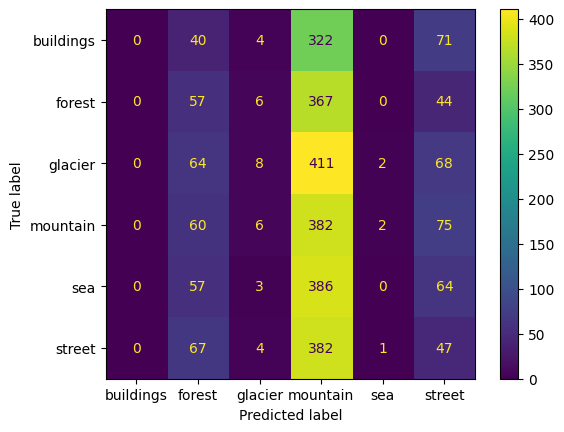

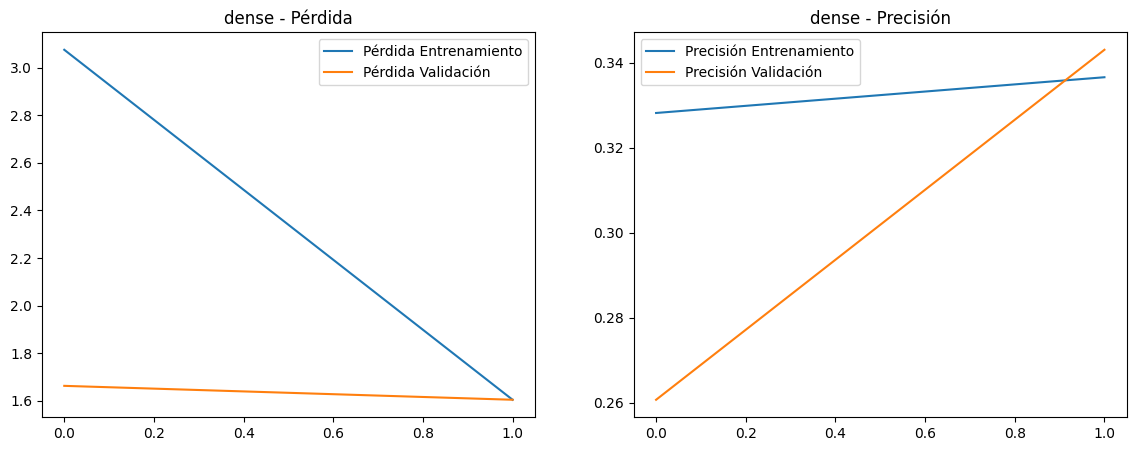

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


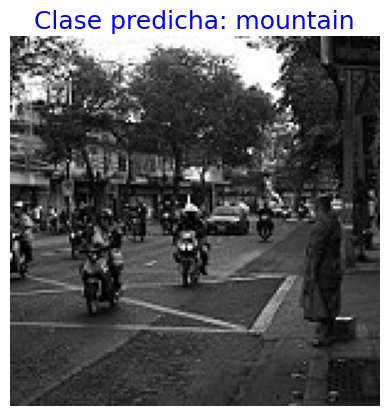

In [35]:
model_name = 'dense'
classifier.build_dense_model()
classifier.train(model_name, epochs=2)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/3.jpg' 
classifier.predict('dense', imagen)

# Construir los modelos de CNN

In [ ]:
model_name = 'cnn'
classifier.build_cnn_model()
classifier.train(model_name, epochs=1)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/11.jpg' 
classifier.predict(model_name, imagen)

# Construir los modelos de Red residual

In [ ]:
model_name = 'residual'
classifier.build_residual_model()
classifier.train(model_name, epochs=1)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/30.jpg' 
classifier.predict(model_name, imagen)

# Construir los modelos atravez de tf learnigin

In [ ]:
model_name = 'efficientnet'
classifier.build_transfer_model()
classifier.train(model_name, epochs=1)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/69.jpg' 
classifier.predict(model_name, imagen)